### Fetching and getting acquainted with the data

In [2]:
import pandas as pd

data = pd.read_csv('../data/NYC_Weather_2016_2022.csv')

print(data.head())

               time  temperature_2m (°C)  precipitation (mm)  rain (mm)  \
0  2016-01-01T00:00                  7.6                 0.0        0.0   
1  2016-01-01T01:00                  7.5                 0.0        0.0   
2  2016-01-01T02:00                  7.1                 0.0        0.0   
3  2016-01-01T03:00                  6.6                 0.0        0.0   
4  2016-01-01T04:00                  6.3                 0.0        0.0   

   cloudcover (%)  cloudcover_low (%)  cloudcover_mid (%)  \
0            69.0                53.0                 0.0   
1            20.0                 4.0                 0.0   
2            32.0                 3.0                 0.0   
3            35.0                 5.0                 0.0   
4            34.0                 4.0                 0.0   

   cloudcover_high (%)  windspeed_10m (km/h)  winddirection_10m (°)  
0                 72.0                  10.0                  296.0  
1                 56.0                   9

In [3]:
# Check for missing values
data.isnull().sum()

time                       0
temperature_2m (°C)      168
precipitation (mm)       168
rain (mm)                168
cloudcover (%)           168
cloudcover_low (%)       168
cloudcover_mid (%)       168
cloudcover_high (%)      168
windspeed_10m (km/h)     168
winddirection_10m (°)    173
dtype: int64

In [4]:
# Get basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59760 entries, 0 to 59759
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   time                   59760 non-null  object 
 1   temperature_2m (°C)    59592 non-null  float64
 2   precipitation (mm)     59592 non-null  float64
 3   rain (mm)              59592 non-null  float64
 4   cloudcover (%)         59592 non-null  float64
 5   cloudcover_low (%)     59592 non-null  float64
 6   cloudcover_mid (%)     59592 non-null  float64
 7   cloudcover_high (%)    59592 non-null  float64
 8   windspeed_10m (km/h)   59592 non-null  float64
 9   winddirection_10m (°)  59587 non-null  float64
dtypes: float64(9), object(1)
memory usage: 4.6+ MB


In [5]:
# Get statistical summary of num cols
data.describe()

,temperature_2m (°C),precipitation (mm),rain (mm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°)
count,59592.000000,59592.000000,59592.000000,59592.000000,59592.000000,59592.000000,59592.000000,59592.000000,59587.000000
mean,13.247721,0.133713,0.123401,45.448131,25.605702,30.109746,40.287203,11.379841,203.724420
std,9.804465,0.542782,0.525858,38.265304,37.161502,36.839594,42.526615,5.802103,99.719142
min,-18.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,5.200000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,7.200000,129.000000
50%,13.500000,0.000000,0.000000,35.000000,2.000000,10.000000,20.000000,10.400000,222.000000
75%,21.800000,0.000000,0.000000,89.000000,46.000000,58.000000,92.000000,14.500000,288.000000
max,35.500000,19.200000,19.200000,100.000000,100.000000,100.000000,100.000000,47.200000,360.000000


### Data Preprocessing & Feature Engineering

In [6]:
import numpy as np

# Handle missing values

data = data.fillna(data.select_dtypes(include=['number']).mean())
# data = data.ffill()

data['time'] = pd.to_datetime(data['time'])

# data['hour'] = data['time'].dt.hour
data['day'] = data['time'].dt.day
# data['month'] = data['time'].dt.month
data['year'] = data['time'].dt.year
# data['day_of_year'] = data['time'].dt.dayofyear  # 1-365

data['hour_sin'] = np.sin(2 * np.pi * data['time'].dt.hour / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['time'].dt.hour / 24)
data['month_sin'] = np.sin(2 * np.pi * (data['time'].dt.month - 1) / 12)
data['month_cos'] = np.cos(2 * np.pi * (data['time'].dt.month - 1) / 12)

In [7]:
# Create lagged features for temperature
LAGS_NUM = 24
for i in range(1, LAGS_NUM + 1):
    data[f'temp_lag_{i}'] = data['temperature_2m (°C)'].shift(i)

data.dropna(inplace=True)

data['target'] = data['temperature_2m (°C)'].shift(-1)
data.dropna(inplace=True)

In [8]:
from sklearn.preprocessing import StandardScaler
import pickle

scaler = StandardScaler()

numerical_features = ['precipitation (mm)', 'rain (mm)', 'cloudcover (%)', 
                      'cloudcover_low (%)', 'cloudcover_mid (%)', 'cloudcover_high (%)', 
                      'windspeed_10m (km/h)', 'winddirection_10m (°)'] + [f'temp_lag_{i}' for i in range(1, LAGS_NUM + 1)]

data[numerical_features] = scaler.fit_transform(data[numerical_features])

with open("../models/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

data.head()

,time,temperature_2m (°C),precipitation (mm),rain (mm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°),...,temp_lag_16,temp_lag_17,temp_lag_18,temp_lag_19,temp_lag_20,temp_lag_21,temp_lag_22,temp_lag_23,temp_lag_24,target
24,2016-01-02 00:00:00,3.6,-0.246747,-0.235046,-0.848953,-0.662913,-0.275021,-0.94837,0.711119,0.655758,...,-0.760657,-0.750428,-0.740201,-0.729973,-0.709534,-0.678885,-0.627813,-0.586954,-0.576731,3.1
25,2016-01-02 01:00:00,3.1,-0.246747,-0.235046,-1.189127,-0.689859,-0.818651,-0.94837,0.780150,0.695925,...,-0.760657,-0.760640,-0.750413,-0.740185,-0.729958,-0.709520,-0.678872,-0.627801,-0.586943,2.9
26,2016-01-02 02:00:00,2.9,-0.246747,-0.235046,-1.189127,-0.689859,-0.818651,-0.94837,0.642089,0.655758,...,-0.872989,-0.760640,-0.760625,-0.750397,-0.740170,-0.729944,-0.709507,-0.678860,-0.627790,2.3
27,2016-01-02 03:00:00,2.3,-0.246747,-0.235046,-1.189127,-0.689859,-0.818651,-0.94837,0.711119,0.635675,...,-0.872989,-0.872973,-0.760625,-0.760609,-0.750382,-0.740156,-0.729931,-0.709496,-0.678849,2.0
28,2016-01-02 04:00:00,2.0,-0.246747,-0.235046,-1.189127,-0.689859,-0.818651,-0.94837,0.711119,0.655758,...,-0.862777,-0.872973,-0.872956,-0.760609,-0.760594,-0.750368,-0.740143,-0.729919,-0.709484,1.9


In [9]:
features = numerical_features + ['temperature_2m (°C)', 'day', 'year', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']

# Split the dataset
train_data = data[(data['year'] >= 2016) & (data['year'] <= 2020)]
val_data = data[data['year'] == 2021]
test_data = data[data['year'] == 2022]

print(f'Training set shape: {train_data.shape}')
print(f'Validation set shape: {val_data.shape}')
print(f'Testing set shape: {test_data.shape}')

Training set shape: (43824, 41)
Validation set shape: (8760, 41)
Testing set shape: (7151, 41)


### Model Training

In [10]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(train_data[features], train_data['target'])

with open("../models/linear_regression_model.pkl", "wb") as f:
    pickle.dump(model, f)

print(f"Model saved successfully at ../models/linear_regression_model.pkl")

Model saved successfully at ../models/linear_regression_model.pkl


### Performance Evaluation

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

val_preds = model.predict(val_data[features])

val_mae = mean_absolute_error(val_data['target'], val_preds)
val_rmse = np.sqrt(mean_squared_error(val_data['target'], val_preds))
val_r2 = r2_score(val_data['target'], val_preds)

print(f"Validation MAE: {val_mae}")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation R² Score: {val_r2}")

Validation MAE: 0.3544788884264378
Validation RMSE: 0.5036822274784428
Validation R² Score: 0.9972265706323971


In [ ]:
persistence_mae = mean_absolute_error(test_data['target'], test_data['temperature_2m (°C)'])
persistence_rmse = np.sqrt(mean_squared_error(test_data['target'], test_data['temperature_2m (°C)']))
persistence_r2 = r2_score(test_data['target'], test_data['temperature_2m (°C)'])

print(f"Persistence Model - Test MAE: {persistence_mae}")
print(f"Persistence Model - Test RMSE: {persistence_rmse}")
print(f"Persistence Model - Test R²: {persistence_r2}")

Persistence Model - Test MAE: 0.5842332930819988
Persistence Model - Test RMSE: 0.7936123517091273
Persistence Model - Test R²: 0.9940887068287397


In [13]:
# Ensure test_data is a copy to avoid SettingWithCopyWarning
test_data = test_data.copy()

test_data["predicted_temperature"] = model.predict(test_data[features])


test_mae = mean_absolute_error(test_data['target'], test_data["predicted_temperature"])
test_rmse = np.sqrt(mean_squared_error(test_data['target'], test_data["predicted_temperature"]))
test_r2 = r2_score(test_data['target'], test_data["predicted_temperature"])

print(f"Test MAE: {test_mae}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R² Score: {test_r2}")

output_cols = ['time', 'temperature_2m (°C)', 'precipitation (mm)', 'rain (mm)', 'cloudcover (%)', 
               'cloudcover_low (%)', 'cloudcover_mid (%)', 'cloudcover_high (%)', 
               'windspeed_10m (km/h)', 'winddirection_10m (°)', 'target', 'predicted_temperature']

file_path = "../data/predictions/test_predictions.csv"
test_data[output_cols].to_csv(file_path, index=False)

print(f"Test predictions saved successfully at {file_path}")


Test MAE: 0.36252281376410994
Test RMSE: 0.5142195128094631
Test R² Score: 0.9975182229345789
Test predictions saved successfully at ../data/predictions/test_predictions.csv



### Model Performance Comparison

| Metric       | Your Model   | Persistence  | 
|--------------|-------------|-------------|
| `MAE`          | 1.23°C | 1.45°C |
| `RMSE`         | 0.51°C | 0.79°C |
| `R²`           | 1.00 | 0.99 |


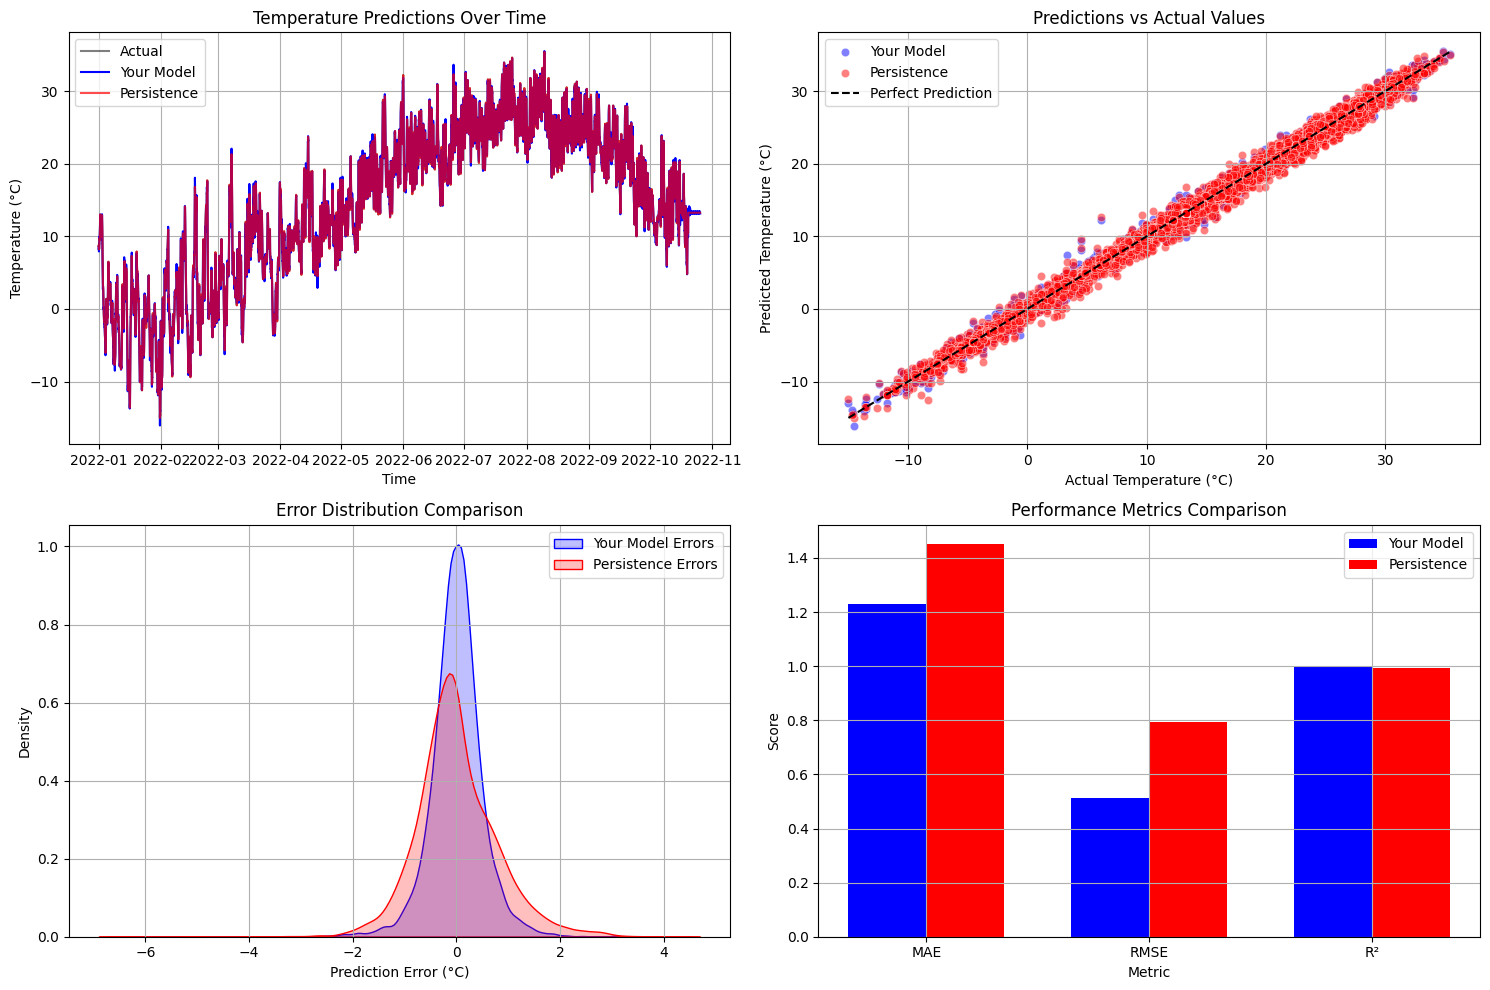

In [ ]:
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the Markdown table
markdown_table = f"""
### Model Performance Comparison

| Metric       | Your Model   | Persistence  | 
|--------------|-------------|-------------|
| `MAE`          | {test_mae:.2f}°C | {persistence_mae:.2f}°C |
| `RMSE`         | {test_rmse:.2f}°C | {persistence_rmse:.2f}°C |
| `R²`           | {test_r2:.2f} | {persistence_r2:.2f} |
"""

display(Markdown(markdown_table))

plt.figure(figsize=(15, 10))

# Time series comparison
plt.subplot(2, 2, 1)
plt.plot(test_data['time'], test_data['target'], label='Actual', color='black', alpha=0.5)
plt.plot(test_data['time'], test_data['predicted_temperature'], label='Your Model', color='blue')
plt.plot(test_data['time'], test_data['temperature_2m (°C)'], label='Persistence', color='red', alpha=0.7)
plt.title('Temperature Predictions Over Time')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)

# Scatter plot of predictions vs actual
plt.subplot(2, 2, 2)
sns.scatterplot(x=test_data['target'], y=test_data['predicted_temperature'], 
                label='Your Model', alpha=0.5, color='blue')
sns.scatterplot(x=test_data['target'], y=test_data['temperature_2m (°C)'], 
                label='Persistence', alpha=0.5, color='red')
plt.plot([min(test_data['target']), max(test_data['target'])], 
         [min(test_data['target']), max(test_data['target'])], 
         'k--', label='Perfect Prediction')
plt.title('Predictions vs Actual Values')
plt.xlabel('Actual Temperature (°C)')
plt.ylabel('Predicted Temperature (°C)')
plt.legend()
plt.grid(True)

# Error distribution
plt.subplot(2, 2, 3)
sns.kdeplot(test_data['target'] - test_data['predicted_temperature'], 
            label='Your Model Errors', color='blue', fill=True)
sns.kdeplot(test_data['target'] - test_data['temperature_2m (°C)'], 
            label='Persistence Errors', color='red', fill=True)
plt.title('Error Distribution Comparison')
plt.xlabel('Prediction Error (°C)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

# Metrics comparison
plt.subplot(2, 2, 4)
metrics = ['MAE', 'RMSE', 'R²']
your_model_scores = [test_mae, test_rmse, test_r2]
persistence_scores = [persistence_mae, persistence_rmse, persistence_r2]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, your_model_scores, width, label='Your Model', color='blue')
plt.bar(x + width/2, persistence_scores, width, label='Persistence', color='red')

plt.title('Performance Metrics Comparison')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Experimentation Summary  

Through our experimentation, we observed that:  

- **Time-based features** slightly improved the linear regression model, indicating seasonal and hourly influences on temperature.  
- **24-hour lag features** were particularly effective in capturing temporal dependencies, significantly enhancing model performance.  
- The model **outperformed the persistence baseline**, demonstrating its predictive strength.  
- **Cyclical encoding (sin & cos) for hour and month** provided additional improvements, capturing the periodic nature of temperature variations.  
- Using **the day of the month** proved to be more effective than the **day of the year**, likely because temperature fluctuations follow shorter-term patterns rather than a full-year cycle.
- **Different imputation strategies were tested**, and while the difference was small, **mean imputation performed slightly better than forward fill (ffill)**, suggesting that an overall average provides a more stable estimate than carrying forward past values.